**Individual Project**

Consider the second order IVP that governs the motion of the projectile under a crude approximation for drag. Let us say that you are about to hit a baseball and you want to know how far it will go. The equations of motion are given by Newton's second law. Defining the baseball to have mass $m$ and vector position and velocity $\boldsymbol{x}=[x_x, x_y]^T$, $\boldsymbol{v}=[v_x, v_y]^T:=\dot{\boldsymbol{x}}=[\dot{x}_x, \dot{x}_y]^T$, respectively, we have for the $x$- and $y$- force balances:
\begin{gather}
  \ddot{x}_x = -\frac{1}{m} D_x, \tag{1} \\
  \ddot{x}_y = \left( -g -\frac{ D_y}{m} \right) \tag{2},
\end{gather}
where $D_x$ and $D_y$ are the $x$- and $y$- components of a crude model for the drag force $\boldsymbol{D}$, given by 
\begin{equation}
   D_x = \alpha ||\boldsymbol{v}|| v_x, \quad D_y = \alpha ||\boldsymbol{v}|| v_y. \tag{3}
\end{equation}

In these expressions for drag, the constant $\alpha = \rho CA/2$, where $\rho$ is the density of air, $A$ is the silhouette area (the body's area as seen from the front), and $C$ is the *drag coefficient* that depends on the shape of the body.

**Q3.** For the case **without** drag considerations, determine the analytical solution. Then, apply your numerical method (AB3) to that problem (without drag) for decreasing values of $\Delta t$ and observe the error convergence plot. Does your convergence plot scale differently from the $O(\Delta t^3)$ that you derived in **Q2**? Why or why not? Explain the plot using a markdown cell. Be sure to pick appropriate initial conditions and time step size $\Delta t$. 

Define true function without drag

In [50]:
# don't forget to import any Python libraries required for your function...
import numpy as np
def f_true(u):
    u_dot = np.array([u[2],u[3],0,ay])
    return u_dot

Define analytical solution without drag

In [51]:
def analytical(u_0, T, delta_t,ax,ay):
    """Returns the analytical solution of the system state
    
    Parameters
    ----------
    u_0 : array
        1 x 4 array defining the initial state vector u_0 where
        
        u[0] = initial x position
        u[1] = initial y position
        u[2] = initial x velocity
        u[3] = initial y velocity
        
    T : float_like
        Final time T
    delta_t : float_like
        Time step size where delta_t = t_{k+1} - t_k
    ax : x-direction acceleration
    ay : y-direction acceleration
        
    Returns
    -------
    u_analytical
    times_analytical
    
    """    
    times_analytical = np.arange(0, T+delta_t, delta_t)
    u_analytical = np.zeros((len(times_analytical),len(u_0)))
    #print(u_analytical.shape)
    
    x_0  = u_0[0]
    y_0  = u_0[1]
    vx_0 = u_0[2]
    vy_0 = u_0[3]
    
    for i in range(len(times_analytical)):
        if i == 0:
            u_analytical[0] = u_0
        else: 
            x = x_0 + vx_0*times_analytical[i] + .5*ax*times_analytical[i]**2
            y = y_0 + vy_0*times_analytical[i] + .5*ay*times_analytical[i]**2
            vx = vx_0 + ax*times_analytical[i]
            vy = vy_0 + ay*times_analytical[i]
            u_analytical[i] = np.array([x,y,vx,vy])
            
    return u_analytical, times_analytical

Define 4-stage Runge-Kutta for AB3 method

In [52]:
def runge_kutta(u_k, delta_t):
    y1 = f_true(u_k)
    y2 = f_true(u_k + (1/2)*delta_t*y1)
    y3 = f_true(u_k + (1/2)*delta_t*y2)
    y4 = f_true(u_k + delta_t*y3)
    u_kplus1 = u_k + (1/6)*delta_t*(y1 + 2*y2 + 2*y3 + y4)
    return u_kplus1

Define ABM3 method

In [53]:
import numpy as np
"""Returns the predicted system evolution over time using the forward Euler method.

This function assumes an f_true(u) function is globally available for calculating the true function value at u.

Parameters
----------
u_0 : array
    1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
T : float_like
    Final time T
delta_t : float_like
    Time step size where delta_t = t_{k+1} - t_k

Returns
-------
u : array
    K x N array of the predicted states where row k is the state at time step k and K = number of time steps
times : array_like
    Length K vector containing the times t corresponding to time steps
"""
def ivp_abm3(u_0, T, delta_t):
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        elif i == 1:
            u[1] = runge_kutta(u[0], delta_t)
        elif i == 2:
            u[2] = runge_kutta(u[1], delta_t)
        else :
            #Adams-Bashforth Predictor
            u[i] = delta_t/12 * (5*f_true(u[i-3]) - 16*f_true(u[i-2]) + 23*f_true(u[i-1])) + u[i-1]
            #Admas-Moulton Corrector
            u[i] = u[i-1] + delta_t/24 * (f_true(u[i-3]) - 5*f_true(u[i-2]) + 19*f_true(u[i-1]) + 9*f_true(u[i]))
    return u, times

def ivp_ab5(u_0, T, delta_t):
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros((len(times),len(u_0)))
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        elif i == 1:
            u[1] = runge_kutta(u[0], delta_t)
        elif i == 2:
            u[2] = runge_kutta(u[1], delta_t)
        elif i == 3:
            u[3] = runge_kutta(u[2], delta_t)
        elif i == 4:
            u[4] = runge_kutta(u[3], delta_t)
        else :
            u[i] = delta_t/720 * (251*f_true(u[i-5]) - 1274*f_true(u[i-4]) + 2616*f_true(u[i-3]) - 2774*f_true(u[i-2]) + 1901*f_true(u[i-1])) + u[i-1]
    return u, times

def ivp_RK4(u_0, T, delta_t):
    times = np.arange(0,T+delta_t,delta_t)
    u = np.zeros([len(times),len(u_0)])
    for i in range(len(times)):
        if i == 0:
            u[0] = u_0
        else:
            u[i] = runge_kutta(u[i-1], delta_t)
    return u, times

Define AB5 error

In [54]:
"""Returns the error in the predicted final system state when using delta_t relative to delta_t_baseline for the 2-step Adams Bashforth method.

This function assumes an f_true(u) function is globally available for calculating the true function value at u.

Parameters
----------
u_0 : array
    1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
T : float_like
    Final time T
delta_t : float_like
    Time step size where delta_t = t_{k+1} - t_k
delta_t_basleine : float_like
    Baseline time step size where delta_t_baseline = t_{k+1} - t_k

Returns
-------
err : float
    Error calculated as ||u_final_delta_t - u_final_delta_t_baseline|| / ||u_final_delta_t_baseline||, where u_final_delta_t is the final predicted state when using delta_t
"""
def ivp_abm3_error(u_0, T, delta_t):
    u_abm3, times_abm3 = ivp_abm3(u_0, T, delta_t)
    u_t_abm3_final = u_abm3[-1]
    # predict final state using delta_t_baseline
    u, times = analytical(u_0, T, delta_t, ax, ay)
    u_t_analytical_final = u[-1]
    # calculate error
    e = np.linalg.norm(u_t_abm3_final - u_t_analytical_final)/np.linalg.norm(u_t_analytical_final)
    return e

def ivp_ab5_error(u_0, T, delta_t):
    u_ab5, times_ab5 = ivp_ab5(u_0, T, delta_t)
    u_t_ab5_final = u_ab5[-1]
    # predict final state using delta_t_baseline
    u, times = analytical(u_0, T, delta_t, ax, ay)
    u_t_analytical_final = u[-1]
    # calculate error
    e = np.linalg.norm(u_t_ab5_final - u_t_analytical_final)/np.linalg.norm(u_t_analytical_final)
    return e

def ivp_RK4_error(u_0, T, delta_t):
    u_RK4, times_RK4 = ivp_RK4(u_0, T, delta_t)
    u_t_RK4_final = u_RK4[-1]
    # predict final state using delta_t_baseline
    u, times = analytical(u_0, T, delta_t, ax, ay)
    u_t_analytical_final = u[-1]
    # calculate error
    e = np.linalg.norm(u_t_RK4_final - u_t_analytical_final)/np.linalg.norm(u_t_analytical_final)
    return e

Plot AB3 error compared to analytical solution and plot trajejectory predicted by AB3 method compared to trajectory of analytical solution

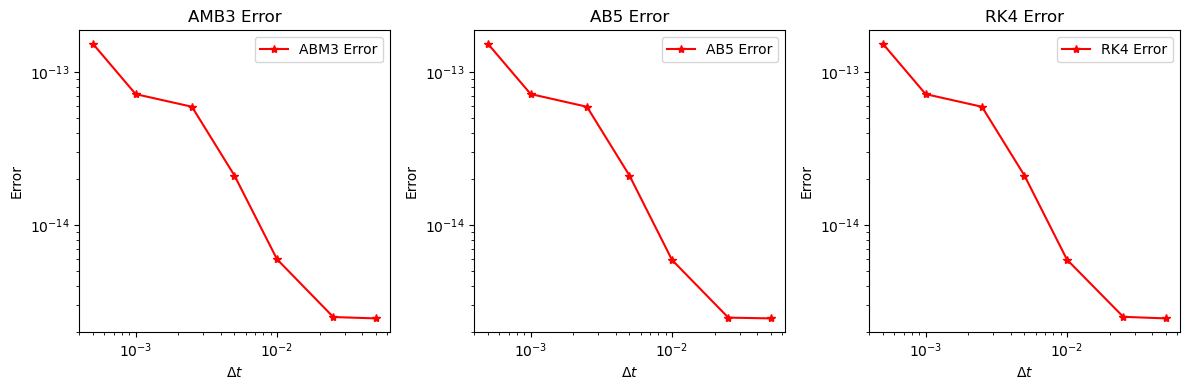

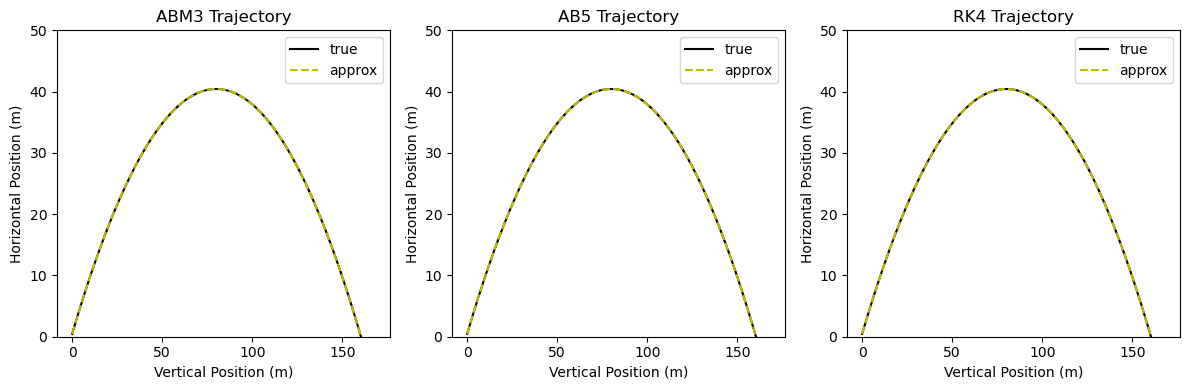

In [59]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

ax = 0
ay = -9.81
vx_0 = 28
vy_0 = 28
x_0 = 0
y_0 = .47

u_0 = np.array([x_0,y_0,vx_0,vy_0])
T = 6
delta_t = 5e-4

u_abm3, times_abm3 = ivp_abm3(u_0, T, delta_t)
u_ab5, times_ab5 = ivp_ab5(u_0, T, delta_t)
u_RK4, times_RK4 = ivp_RK4(u_0, T, delta_t)

# Part 2

ABM3_err_list = []
AB5_err_list = []
RK4_err_list = []

deltas = [5e-2,2.5e-2,1e-2,5e-3,2.5e-3,1e-3,5e-4]
for t in deltas:
    #Get error at each t
    ABM3_err = ivp_abm3_error(u_0, T, t)
    AB5_err = ivp_ab5_error(u_0, T, t)
    RK4_err = ivp_RK4_error(u_0, T, t)
    
    # Save data to lists
    ABM3_err_list.append(ABM3_err)
    AB5_err_list.append(AB5_err)
    RK4_err_list.append(RK4_err)

#Plot Error

fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax1 = fig.add_subplot(131)
ax1.plot(deltas, ABM3_err_list, 'r*-', label = 'ABM3 Error')
ax1.set_xlabel('$\Delta t$')
ax1.set_ylabel('Error')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('AMB3 Error')
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.plot(deltas, AB5_err_list, 'r*-', label = 'AB5 Error')
ax2.set_xlabel('$\Delta t$')
ax2.set_ylabel('Error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('AB5 Error')
ax2.legend()

ax3 = fig.add_subplot(133)
ax3.plot(deltas, RK4_err_list, 'r*-', label = 'RK4 Error')
ax3.set_xlabel('$\Delta t$')
ax3.set_ylabel('Error')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('RK4 Error')
ax3.legend()

#Plot Trajectory

fig2 = plt.figure(figsize=(12, 4), tight_layout=True)
ax4 = fig2.add_subplot(131)
u_a, times_a = analytical(u_0,T,delta_t,ax,ay)
u,times = ivp_abm3(u_0,T,delta_t)
ax4.plot(u_a[:,0],u_a[:,1],"k", label = "true")
ax4.plot(u[:,0],u[:,1],"y--", label = "approx")
ax4.set_ylim(0,50)
ax4.set_xlabel('Vertical Position (m)')
ax4.set_ylabel('Horizontal Position (m)')
ax4.set_title('ABM3 Trajectory')
ax4.legend()

ax5 = fig2.add_subplot(132)
u_a, times_a = analytical(u_0,T,delta_t,ax,ay)
u,times = ivp_ab5(u_0,T,delta_t)
ax5.plot(u_a[:,0],u_a[:,1],"k", label = "true")
ax5.plot(u[:,0],u[:,1],"y--", label = "approx")
ax5.set_ylim(0,50)
ax5.set_xlabel('Vertical Position (m)')
ax5.set_ylabel('Horizontal Position (m)')
ax5.set_title('AB5 Trajectory')
ax5.legend()

ax6 = fig2.add_subplot(133)
u_a, times_a = analytical(u_0,T,delta_t,ax,ay)
u,times = ivp_RK4(u_0,T,delta_t)
ax6.plot(u_a[:,0],u_a[:,1],"k", label = "true")
ax6.plot(u[:,0],u[:,1],"y--", label = "approx")
ax6.set_ylim(0,50)
ax6.set_xlabel('Vertical Position (m)')
ax6.set_ylabel('Horizontal Position (m)')
ax6.set_title('RK4 Trajectory')
ax6.legend()

**Q4.** Pick appropriate values for $\rho$, $C$, and $A$ (citing references as needed). Simulate the problem **with** drag now, using an appropriate value of $\Delta t$. Be sure you justify your choice in $\Delta t$ value. Create a single plot that compares the trajectories with and without drag. In a sentence or two, comment on how drag changes the resulting trajectory.

Set constants

In [35]:
#Defining the initial conditions: 
rho = 1.225
A = 0.004185
m = 0.145
Cd = 0.3
alpha = rho*Cd*A/2

Define function with drag

In [36]:
def f_true_drag(u):
    vx = u[2]
    vy = u[3]
    v_mag = np.sqrt(vx**2 + vy**2)
    ax = (-1/m)*alpha*v_mag*vx
    ay = -9.81-(alpha*v_mag*vy/m)
    
    u_dot = np.array([vx,vy,ax,ay])
    
    return u_dot

Plot trajectory with and without drag

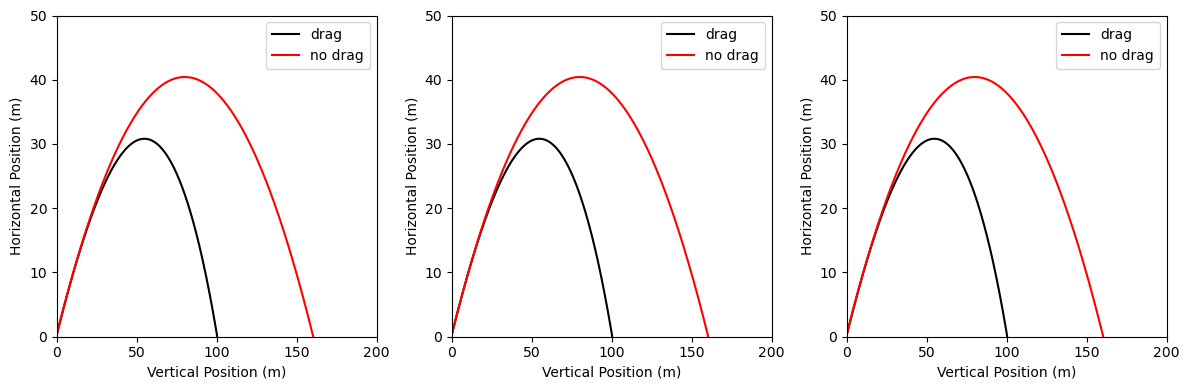

In [64]:
import matplotlib.pyplot as plt
plt.style.use('default')

vx_0 = 28
vy_0 = 28
x_0 = 0
y_0 = .47

u_0 = np.array([x_0,y_0,vx_0,vy_0])
T = 7
delta_t = 5e-4

##Plot AB3 with drag
def f_true(u):
    u_dot = np.array([u[2],u[3],0,ay])
    return u_dot
u,times = ivp_abm3(u_0,T,delta_t)
f_true = f_true_drag

fig1 = plt.figure(figsize=(12, 4), tight_layout=True)
ax1 = fig1.add_subplot(131)
u_d,times_d = ivp_abm3(u_0,T,delta_t)
ax1.plot(u_d[:,0],u_d[:,1],"k", label = "drag")
ax1.plot(u[:,0],u[:,1],"r", label = "no drag")
ax1.set_ylim(0,50)
ax1.set_xlim(0,200)
ax1.set_xlabel('Vertical Position (m)')
ax1.set_ylabel('Horizontal Position (m)')
ax1.legend()

##Plot AM5 with drag
def f_true(u):
    u_dot = np.array([u[2],u[3],0,ay])
    return u_dot
u,times = ivp_ab5(u_0,T,delta_t)
f_true = f_true_drag

ax2 = fig1.add_subplot(132)
u_d,times_d = ivp_ab5(u_0,T,delta_t)
ax2.plot(u_d[:,0],u_d[:,1],"k", label = "drag")
ax2.plot(u[:,0],u[:,1],"r", label = "no drag")
ax2.set_ylim(0,50)
ax2.set_xlim(0,200)
ax2.set_xlabel('Vertical Position (m)')
ax2.set_ylabel('Horizontal Position (m)')
ax2.legend()

##Plot AM5 with drag
def f_true(u):
    u_dot = np.array([u[2],u[3],0,ay])
    return u_dot
u,times = ivp_RK4(u_0,T,delta_t)
f_true = f_true_drag

ax3 = fig1.add_subplot(133)
u_d,times_d = ivp_RK4(u_0,T,delta_t)
ax3.plot(u_d[:,0],u_d[:,1],"k", label = "drag")
ax3.plot(u[:,0],u[:,1],"r", label = "no drag")
ax3.set_ylim(0,50)
ax3.set_xlim(0,200)
ax3.set_xlabel('Vertical Position (m)')
ax3.set_ylabel('Horizontal Position (m)')
ax3.legend()

**Q5.(Extra credit (up to 5 points))** Now, observe the error convergence plot for the case **with drag**. (You can use u at 'delta_t_baseline' as the reference since there is no analytical solution this time). Does the error convergence look similar to the one obtained for **Q3**? Why or why not? Explain the reason in a markdown cell below

In [68]:
"""Returns the error in the predicted final system state when using delta_t relative to delta_t_baseline for the 2-step Adams Bashforth method.

This function assumes an f_true(u) function is globally available for calculating the true function value at u.

Parameters
----------
u_0 : array
    1 x N array defining the initial state vector u_0 where N = number of state variables = |u|
T : float_like
    Final time T
delta_t : float_like
    Time step size where delta_t = t_{k+1} - t_k
delta_t_basleine : float_like
    Baseline time step size where delta_t_baseline = t_{k+1} - t_k

Returns
-------
err : float
    Error calculated as ||u_final_delta_t - u_final_delta_t_baseline|| / ||u_final_delta_t_baseline||, where u_final_delta_t is the final predicted state when using delta_t
"""
f_true = f_true_drag
def ivp_abm3_error_drag(u_0, T, delta_t, delta_t_baseline):
    # predict final state using delta_t
    u_t, times_t = ivp_abm3(u_0, T, delta_t)
    u_final_delta_t = u_t[-1]

    # predict final state using delta_t_baseline
    u_t_baseline, times_baseline = ivp_abm3(u_0, T, delta_t_baseline)
    u_final_delta_t_baseline = u_t_baseline[-1]

    # calculate error
    err = np.linalg.norm(u_final_delta_t-u_final_delta_t_baseline)/np.linalg.norm(u_final_delta_t_baseline)
    
    return err

def ivp_ab5_error_drag(u_0, T, delta_t, delta_t_baseline):
    # predict final state using delta_t
    u_t, times_t = ivp_ab5(u_0, T, delta_t)
    u_final_delta_t = u_t[-1]

    # predict final state using delta_t_baseline
    u_t_baseline, times_baseline = ivp_ab5(u_0, T, delta_t_baseline)
    u_final_delta_t_baseline = u_t_baseline[-1]

    # calculate error
    err = np.linalg.norm(u_final_delta_t-u_final_delta_t_baseline)/np.linalg.norm(u_final_delta_t_baseline)
    
    return err

def ivp_RK4_error_drag(u_0, T, delta_t, delta_t_baseline):
    # predict final state using delta_t
    u_t, times_t = ivp_RK4(u_0, T, delta_t)
    u_final_delta_t = u_t[-1]

    # predict final state using delta_t_baseline
    u_t_baseline, times_baseline = ivp_RK4(u_0, T, delta_t_baseline)
    u_final_delta_t_baseline = u_t_baseline[-1]

    # calculate error
    err = np.linalg.norm(u_final_delta_t-u_final_delta_t_baseline)/np.linalg.norm(u_final_delta_t_baseline)
    
    return err

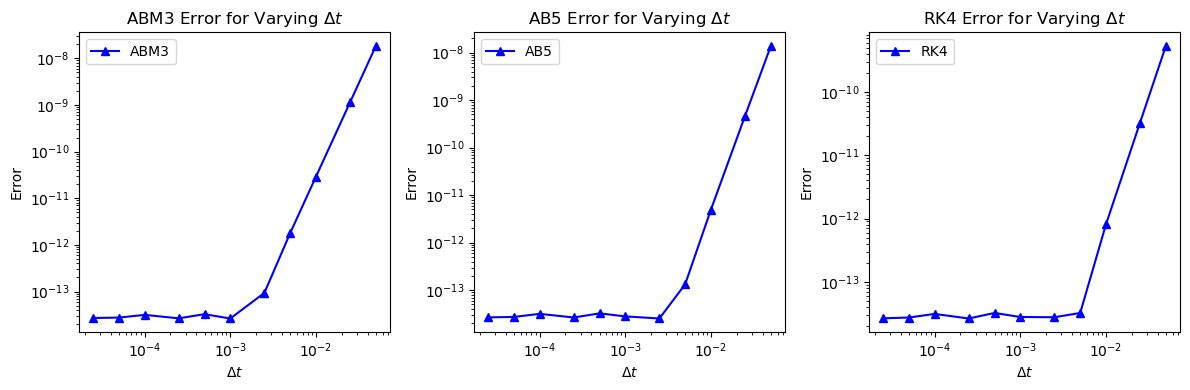

In [76]:
import matplotlib.pyplot as plt
plt.style.use('default')

##PART 1
u_0 = [0,0,28,28]
T = 7
delta_t = 1e-5

## PART 2
deltats = [5e-2, 2.5e-2, 1e-2, 5e-3, 2.5e-3, 1e-3, 5e-4, 2.5e-4, 1e-4, 5e-5, 2.5e-5]
delta_t_baseline = 1e-5

abm3_error_drag = []
ab5_error_drag = []
RK4_error_drag = []

for i in deltats:
    abm3_error_drag.append(ivp_abm3_error_drag(u_0, T, i, delta_t_baseline))
    ab5_error_drag.append(ivp_ab5_error_drag(u_0, T, i, delta_t_baseline))
    RK4_error_drag.append(ivp_RK4_error_drag(u_0, T, i, delta_t_baseline))
    
fig2 = plt.figure(figsize=(12, 4), tight_layout=True)

ax1 = fig2.add_subplot(131)
ax1.plot(deltats,abm3_error_drag,"b^-",label='ABM3')
ax1.set_title('ABM3 Error for Varying $\Delta{t}$')
ax1.set_xlabel('$\Delta{t}$')
ax1.set_ylabel('Error')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()

ax2 = fig2.add_subplot(132)
ax2.plot(deltats,ab5_error_drag,"b^-",label='AB5')
ax2.set_title('AB5 Error for Varying $\Delta{t}$')
ax2.set_xlabel('$\Delta{t}$')
ax2.set_ylabel('Error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()

ax3 = fig2.add_subplot(133)
ax3.plot(deltats,RK4_error_drag,"b^-",label='RK4')
ax3.set_title('RK4 Error for Varying $\Delta{t}$')
ax3.set_xlabel('$\Delta{t}$')
ax3.set_ylabel('Error')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()

Q5 MARKDOWN

Looking at the error plot, the error scales as expected with a $O(\Delta t^3)$ relationship. As can be seen in the plot, the slope is 3, which, in a log-log graph, is indicative of a 3rd-order power relationship. This is unsurprising as the AB3 method, a third order method, is being applied to a third order problem in the case with drag. I also tested to see where the power relationship would break down. The error appears to bottom out at approximately the same 10e-14 range as did in question 3, which supports my previous claim that the limits of error were likely being reached due to computer hardware limitations. We see that the relationship breaks down at $\Delta t$ values smaller than 2.5e-4, which justifies the $\Delta t$ value that I chose for question 4.